# Assignment 1: Entanglement-Based Quantum Communication


In [1]:
!pip install qiskit qiskit-aer matplotlib

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer
import matplotlib.pyplot as plt
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.7 MB/s eta 0:00:00


# Problem 1: Quantum Teleportation


## Step 1: Arbitrary Qubit Preparation
Choose theta and phi values avoiding special angles.

In [2]:
theta = 1.3
phi   = 2.3

print(f'theta = {theta} rad')
print(f'phi   = {phi} rad')


theta = 1.3 rad
phi   = 2.3 rad


## Full Teleportation Circuit
Qubits: 0 = Alice's state, 1 = Alice's entangled qubit, 2 = Bob's entangled qubit

In [3]:
qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(1, 'c')
qc = QuantumCircuit(qr, cr)

qc.ry(theta, 0)
qc.rz(phi, 0)
qc.barrier(label='|ψ⟩ ready')

qc.h(1)
qc.cx(1, 2)
qc.barrier(label='Bell pair')

qc.cx(0, 1)
qc.h(0)
qc.barrier(label='Bell meas')

qc.cx(1, 2)
qc.cz(0, 2)
qc.barrier(label='correction')

qc.rz(-phi, 2)
qc.ry(-theta, 2)
qc.barrier(label='U†')

qc.measure(2, 0)

print('Circuit built successfully.')
print(f'Total gates: {qc.size()}')

Circuit built successfully.
Total gates: 11


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=187dd9514bf15640c3246b483552425c3f5c990cb6f5561e83c7226b36f9e761
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
=== Full Teleportation Circuit ===


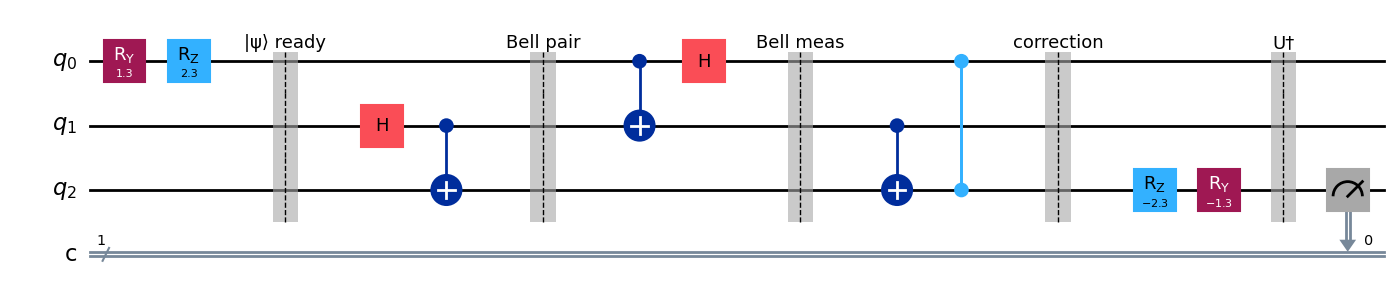

In [4]:
!pip install pylatexenc
print('=== Full Teleportation Circuit ===')
qc.draw('mpl', fold=40)

In [5]:
# Simulate with 5000 shots
simulator = AerSimulator()
job = simulator.run(qc, shots=5000)
result = job.result()
counts = result.get_counts()

print('Measurement counts:', counts)
print(f"P(|0⟩) = {counts.get('0', 0) / 5000 * 100:.2f}%")
print(f"P(|1⟩) = {counts.get('1', 0) / 5000 * 100:.2f}%")

plot_histogram(counts, title='Quantum Teleportation — Bob\'s Measurement (5000 shots)')
plt.tight_layout()
plt.show()


Measurement counts: {'0': 5000}
P(|0⟩) = 100.00%
P(|1⟩) = 0.00%


<Figure size 640x480 with 0 Axes>

## Part B: Conceptual Questions

### Q1. What do you observe in the histogram after applying U†?

Bob measures **|0⟩ with ~100% probability**. The histogram shows almost all 5000 shots landing on '0', confirming successful teleportation.

### Q2. Why does applying U† verify teleportation?

The teleportation protocol transfers Alice's state |ψ⟩ = U|0⟩ to Bob's qubit. After teleportation, Bob's qubit is in state |ψ⟩.  
Applying U† (the inverse unitary) to Bob's qubit gives:  
> U†|ψ⟩ = U†(U|0⟩) = (U†U)|0⟩ = I|0⟩ = **|0⟩**

Since U†U = I (identity), the qubit returns to |0⟩. A 100% measurement of |0⟩ thus **confirms** that Bob received exactly |ψ⟩ — any error in teleportation would yield a different state, and U† would not return it to |0⟩.

### Q3. Why were we able to avoid sending classical bits?

In the standard protocol, Alice measures qubits 0 and 1 (collapsing the state) and phones Bob with 2 classical bits so he can apply the correct Pauli correction (I, X, Z, or XZ).  

In this circuit the entire process remains **unitary** (no measurement, no collapse). The controlled-X and controlled-Z gates (CX(1,2) and CZ(0,2)) coherently apply **all four possible corrections simultaneously** as superpositions controlled by qubits 0 and 1. Because the entanglement structure guarantees these controls exactly track which correction is needed, the right correction is applied automatically without Alice communicating anything.  

The key difference: the real protocol uses projective measurement + classical communication (limited by the speed of light); the fully-quantum version keeps everything in superposition and is only valid as a verification tool — it **cannot be used** to send information faster than light because the quantum correlations are non-local but not signalling.


---
# Problem 2: Superdense Coding


## Part A: Qiskit Implementation
We will encode the message **10** as an example.

In [9]:
message = '10'

qr2 = QuantumRegister(2, 'q')
cr2 = ClassicalRegister(2, 'c')
qc2 = QuantumCircuit(qr2, cr2)

qc2.h(0)
qc2.cx(0, 1)
qc2.barrier(label='Bell pair')


if message == '00':
    pass
elif message == '01':
    qc2.z(0)
elif message == '10':
    qc2.x(0)
elif message == '11':
    qc2.x(0)
    qc2.z(0)

print(f'Encoding message: {message}')
qc2.barrier(label=f'encode {message}')

qc2.cx(0, 1)
qc2.h(0)
qc2.barrier(label='decode')

qc2.measure([0, 1], [0, 1])

print('Superdense coding circuit built.')


Encoding message: 10
Superdense coding circuit built.


=== Superdense Coding Circuit ===


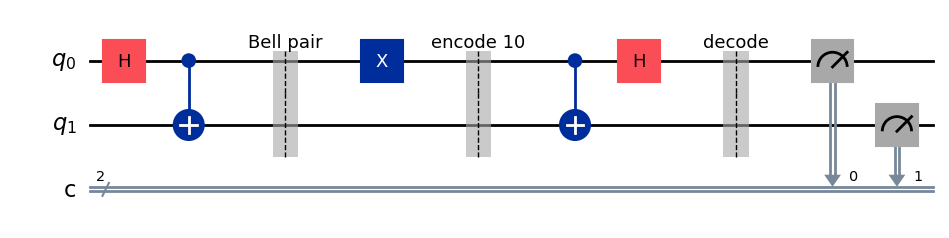

In [10]:
print('=== Superdense Coding Circuit ===')
qc2.draw('mpl', fold=30)


In [11]:
job2 = simulator.run(qc2, shots=5000)
result2 = job2.result()
counts2 = result2.get_counts()

print(f'Message sent: {message}')
print('Measurement counts:', counts2)

received = max(counts2, key=counts2.get)
received_reordered = received[::-1]
print(f'Received message (decoded): {received_reordered}')

plot_histogram(counts2, title=f'Superdense Coding — Message "{message}" (5000 shots)')
plt.tight_layout()
plt.show()


Message sent: 10
Measurement counts: {'10': 5000}
Received message (decoded): 01


<Figure size 640x480 with 0 Axes>